### Oscar Ko - Data 71200

---

# PROJECT 3: Unsupervised Learning

---

Data from https://www.kaggle.com/datasets/mathchi/diabetes-data-set

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases.

Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

- **Pregnancies**: Number of times pregnant
- **Glucose**: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- **BloodPressure**: Diastolic blood pressure (mm Hg)
- **SkinThickness**: Triceps skin fold thickness (mm)
- **Insulin**: 2-Hour serum insulin (mu U/ml)
- **BMI**: Body mass index (weight in kg/(height in m)^2)
- **DiabetesPedigreeFunction**: Value based on a function that scores likelihood of diabetes based on family history
- **Age**: Age (years)
- **Outcome**: Class variable (0 or 1)

---

# Step 1: Load Data & Testing-Training Split from Project 1

### Import Packages & Data

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mglearn

import warnings
warnings.filterwarnings('ignore')

original_data = pd.read_csv("data/diabetes.csv")

original_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Train-Test Split Stratified

In [49]:
# import package
from sklearn.model_selection import train_test_split


# declare our X inputs and y outcomes
X = original_data.drop("Outcome", axis=1)
y = original_data["Outcome"]


# stratify split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    stratify=y, 
                                                    test_size=0.2,
                                                    random_state=42)

print("X_train.shape = ", X_train.shape)
print("X_test.shape = ", X_test.shape)

print("y_train.shape = ", y_train.shape)
print("y_test.shape = ", y_test.shape)

print("\n")
print("y_train class proportions: \n", y_train.value_counts(normalize=True))

print("\n")
print("y_test class proportions: \n", y_test.value_counts(normalize=True))

X_train.shape =  (614, 8)
X_test.shape =  (154, 8)
y_train.shape =  (614,)
y_test.shape =  (154,)


y_train class proportions: 
 0    0.651466
1    0.348534
Name: Outcome, dtype: float64


y_test class proportions: 
 0    0.649351
1    0.350649
Name: Outcome, dtype: float64


### Data Cleaning

- Removing cases of 0 glucose, BMI, and blood pressure because a measurement of 0 is unrealistic in a living patient.

- Removing the entire column of skin thickness because there are too many 0 values.

In [50]:
# create function with all cleaning steps
def clean_set(X_data, y_data):
    
    zero_g = X_data["Glucose"] == 0
    zero_bmi = X_data["BMI"] == 0
    zero_bp = X_data["BloodPressure"] == 0
    
    # get index of cases with 0 Glucose, BMI, or Blood Pressure
    indexes_to_remove = (zero_g | zero_bmi | zero_bp)
    
    # remove the zero cases
    X_data = X_data[~indexes_to_remove]
    y_data = y_data[~indexes_to_remove]
    
    # remove SkinThickness column
    X_data = X_data.drop("SkinThickness", axis=1)
    
    return X_data, pd.DataFrame(y_data)


# clean all the train and test sets together
X_train, y_train = clean_set(X_train, y_train)
X_test, y_test = clean_set(X_test, y_test)


print("X_train.shape = ", X_train.shape)
print("X_test.shape = ", X_test.shape)

print("y_train.shape = ", y_train.shape)
print("y_test.shape = ", y_test.shape)

X_train.shape =  (583, 7)
X_test.shape =  (141, 7)
y_train.shape =  (583, 1)
y_test.shape =  (141, 1)


### Feature Scaling

In [51]:
# FEATURE SCALING ON X_train and X_test ----------------------------------

# Compute the minimum value per feature on the training set
min_on_training = X_train.min(axis=0)

# Compute the range of each feature (max - min) on the training set
range_on_training = (X_train - min_on_training).max(axis=0)

# subtract the min, divide by range
X_train_scaled = (X_train - min_on_training) / range_on_training
    
# use THE SAME transformation on the test set
X_test_scaled = (X_test - min_on_training) / range_on_training


# CHECK THE MINIMUM AND MAXIMUM VALUES ------------

print("Minimum for each feature\n", X_train_scaled.min(axis=0))
print("Maximum for each feature\n", X_train_scaled.max(axis=0))

Minimum for each feature
 Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
dtype: float64
Maximum for each feature
 Pregnancies                 1.0
Glucose                     1.0
BloodPressure               1.0
Insulin                     1.0
BMI                         1.0
DiabetesPedigreeFunction    1.0
Age                         1.0
dtype: float64


### Rename Target Attribute

- The target attribute is named "Outcome." 
- I want to rename it as "hasDiabetes" to be a little more intuitive. 

In [52]:
y_train.rename(columns={'Outcome':'hasDiabetes'}, inplace=True)
y_test.rename(columns={'Outcome':'hasDiabetes'}, inplace=True)

print(y_train.columns)
print(y_test.columns)

Index(['hasDiabetes'], dtype='object')
Index(['hasDiabetes'], dtype='object')


---

# Step 2: PCA for feature selection

### PCA with 95% variance captured

In [53]:
from sklearn.decomposition import PCA

# create instance of PCA with enough features to capture 95% of the variance
pca = PCA(n_components=0.95,
         random_state=42)

# fit PCA model to the scaled data
pca.fit(X_train_scaled)

print('-'*20 + 'Explained variance ratio' + '-'*20)
print(pca.explained_variance_ratio_)

--------------------Explained variance ratio--------------------
[0.35108014 0.23039706 0.10995111 0.09915526 0.08612927 0.06984863
 0.05343853]


### How many features to retain 95% variance?

Text(0, 0.5, 'Principal components')

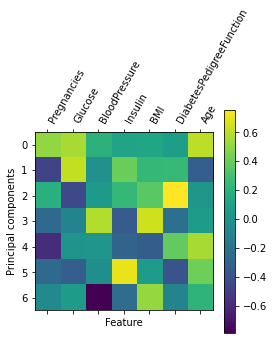

In [54]:
plt.matshow(pca.components_, cmap='viridis')

plt.colorbar()

plt.xticks(range(len(X_train_scaled.columns)),
           X_train_scaled.columns, rotation=60, ha='left')

plt.xlabel("Feature")
plt.ylabel("Principal components")

It seems 7 principal components are needed to capture 95% variance. We started with 7 features, so in terms of dimensions, nothing has changed.

In component 0, all the features have the same sign, so it shows there is a general correlation between all features. 

---

### Evaluate whether this improves your best-performing model from Project 2

**Set up two KNN Models: One without PCA and one with PCA**

In [55]:
# import package
from sklearn.neighbors import KNeighborsClassifier

# create instances of KNN
KNN_regular = KNeighborsClassifier(algorithm='auto',
                            metric='manhattan',
                            n_neighbors=19,
                            weights='distance')

KNN_pca = KNeighborsClassifier(algorithm='auto',
                            metric='manhattan',
                            n_neighbors=19,
                            weights='distance')


# Create KNN Model without PCA --------------------------

# Train model with scaled X train data
KNN_regular.fit(X_train_scaled, y_train)


# Create KNN Model with PCA -----------------------------

# Transform X_sets with PCA
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train model with X train pca
KNN_pca.fit(X_train_pca, y_train)


print(KNN_regular)
print(KNN_pca)

KNeighborsClassifier(metric='manhattan', n_neighbors=19, weights='distance')
KNeighborsClassifier(metric='manhattan', n_neighbors=19, weights='distance')


### Evaluate Both KNN Models

- **Accuracy Scores**
- **Cross Validation Scores**
- **Confusion Matrix**
- **Evaluation Metrics**

In [56]:
# ACCURACY SCORES for both KNN models --------------------------------

# KNN without pca
print("Accuracy on training set (regular): {:.2f}".format(KNN_regular.score(X_train_scaled, y_train)))
print("Accuracy on test set (regular): {:.2f}\n".format(KNN_regular.score(X_test_scaled, y_test)))

# KNN with pca
print("Accuracy on training set (with pca): {:.2f}".format(KNN_pca.score(X_train_pca, y_train)))
print("Accuracy on test set (with pca): {:.2f}\n\n".format(KNN_pca.score(X_test_pca, y_test)))


# CROSS VALIDATION with StratifiedShuffleSplit ------------------------------

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score


sss = StratifiedShuffleSplit(n_splits=5,
                               test_size=0.2, 
                               random_state=42)

cv_scores_regular = cross_val_score(KNN_regular, X_train_scaled, y_train, cv=sss)
cv_scores_with_pca = cross_val_score(KNN_pca, X_train_pca, y_train, cv=sss)

print("Mean of cv_scores (regular): {}\n".format(np.mean(cv_scores_regular)))

print("Mean of cv_scores (with pca): {}".format(np.mean(cv_scores_with_pca)))



# CONFUSION MATRIX ------------------------------------------------------

# Predictions
y_pred = KNN_regular.predict(X_test_scaled)
y_pred_pca = KNN_pca.predict(X_test_pca)

# Confusion Matrix 
from sklearn.metrics import confusion_matrix

confusion_regular = confusion_matrix(y_test, y_pred)
confusion_pca = confusion_matrix(y_test, y_pred_pca)

print("\nConfusion matrix (regular):\n{}".format(confusion_regular))
print("\nConfusion matrix (with pca):\n{}".format(confusion_pca))


# EVALUATION METRICS Precision, Recall, and f1-score ---------------------
from sklearn.metrics import classification_report

print("\nEvaluation Metrics (regular):")
print(classification_report(y_test, 
                            y_pred,
                            target_names=["No diabetes", "Has diabetes"]))

print("Evaluation Metrics (with pca):")
print(classification_report(y_test, 
                            y_pred_pca,
                            target_names=["No diabetes", "Has diabetes"]))

Accuracy on training set (regular): 1.00
Accuracy on test set (regular): 0.76

Accuracy on training set (with pca): 1.00
Accuracy on test set (with pca): 0.74


Mean of cv_scores (regular): 0.7401709401709402

Mean of cv_scores (with pca): 0.7606837606837606

Confusion matrix (regular):
[[81 11]
 [23 26]]

Confusion matrix (with pca):
[[81 11]
 [25 24]]

Evaluation Metrics (regular):
              precision    recall  f1-score   support

 No diabetes       0.78      0.88      0.83        92
Has diabetes       0.70      0.53      0.60        49

    accuracy                           0.76       141
   macro avg       0.74      0.71      0.72       141
weighted avg       0.75      0.76      0.75       141

Evaluation Metrics (with pca):
              precision    recall  f1-score   support

 No diabetes       0.76      0.88      0.82        92
Has diabetes       0.69      0.49      0.57        49

    accuracy                           0.74       141
   macro avg       0.72      0.69    

Overall, PCA with 95% variance didn't change the model's performance too much. 

The accuracy scores and the mean cv_scores are all fairly similar.

KNN with PCA's confusion matrix shows there are two more false negatives than KNN without PCA, so it performed slightly worse. 

In terms of classifying diabetes, any amount of false negatives can be harmful as diabetes gone undiagnosed can worsen someone's health. So in this case, we want the model with higher recall. KNN without PCA is better here. 

---

# Step 3: Compare Clustering Algorithms

- **K-Means**
- **Aggolmerate/Hierarchical**
- **DBSCAN**

## K-Means Elbow Method (Without PCA)

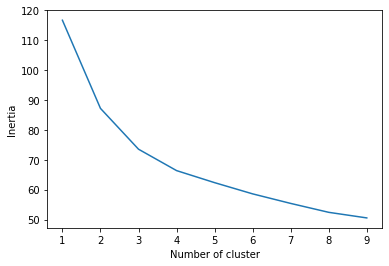

In [57]:
from sklearn.cluster import KMeans

inertiaVals = {}

for k in range(1, 10):
    kmeansTmp = KMeans(n_clusters=k, max_iter=1000).fit(X_train_scaled)
    inertiaVals[k] = kmeansTmp.inertia_ 
    
plt.figure()

plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))

plt.xlabel("Number of cluster")
plt.ylabel("Inertia")

plt.show()

Since the curve is so smooth, it's hard to tell where the inertia starts to flatten out.

It seems either 3 or 4 is a good amount.

But after 4 clusters, the inertia line gets very smooth, so 4 is likely a good number of clusters.

## K-Means Clustering (Without PCA)

When I created a correlation matrix in Project 1, Glucose (r = 0.48) and BMI (r = 0.28) had the highest correlations with the diabetes outcome. 

For visualizing K-Means without PCA, I will use Glucose and BMI.

Text(0, 0.5, 'BMI')

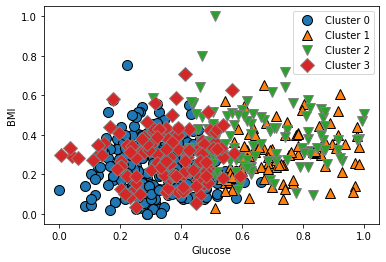

In [58]:
from sklearn.cluster import KMeans

# build the clustering model
kmeans = KMeans(n_clusters=4,
               random_state=42)

kmeans.fit(X_train_scaled)

assignments=kmeans.labels_

mglearn.discrete_scatter(X_train_scaled.loc[:,"Glucose"], 
                         X_train_scaled.loc[:,"BMI"], 
                         assignments)

plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")

plt.xlabel("Glucose")
plt.ylabel("BMI")

Clusters 1 and 2 have higher values of Glucose, so these two clusters might have higher chances of diabetes. Individuals with diabetes have issues dealing with glucose, and higher values are likely to be correlated with having diabetes. 

Data points in clusters 2 and 3 seem to have data points with slightly higher BMI's than the other two clusters. These two clusters may have slightly increased risk of having diabetes as BMI is slightly correlated with diabetes.

With these observations, I suspect the chances of diabetes for each cluster goes like this:

- Green Cluster 2 = High chance of diabetes


- Orange Cluster 1 = High/medium chance of diabetes


- Red Cluster 3 = Low/medium chance of diabetes


- Blue Cluster 0 = Low chance of diabetes





## K-Means Elbow Method (WITH PCA)

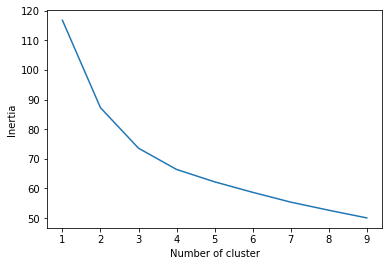

In [59]:
from sklearn.cluster import KMeans

inertiaVals = {}

for k in range(1, 10):
    kmeansTmp = KMeans(n_clusters=k, max_iter=1000).fit(X_train_pca)
    inertiaVals[k] = kmeansTmp.inertia_ 
    
plt.figure()

plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))

plt.xlabel("Number of cluster")
plt.ylabel("Inertia")

plt.show()

The elbow when using K-Means with PCA seems to also be 4.

## K-Means Clustering (WITH PCA)

Text(0, 0.5, 'Second Component')

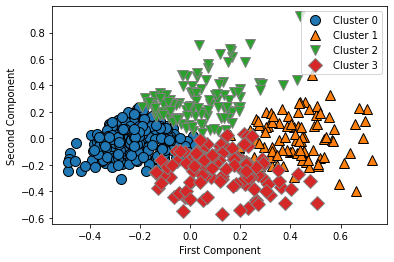

In [60]:
from sklearn.cluster import KMeans

# build the clustering model
kmeans = KMeans(n_clusters=4,
               random_state=42)

kmeans.fit(X_train_pca)

assignments=kmeans.labels_

mglearn.discrete_scatter(X_train_pca[:,0], 
                         X_train_pca[:,1], 
                         assignments)

plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")

plt.xlabel("First Component")
plt.ylabel("Second Component")

The first component explains the most variability compared to the other components, so it's the most important in interpretation.

On the components heatmap from earlier, all the features had the same sign for the first component, so that means there is a general correlation between all features. As one feature increases, other features also tend to increase.

From this I suspect the cluster closer to the right side of the axis has a higher chance of being diabetic cases.


With the second principal component, the PCA heatmap from earlier showed their value signs as:

- **Positive:** Glucose, Insulin, BMI, DiabetesPedigreeFunction


- **Neutral:** BloodPressure


- **Negative:** Pregnancies, Age


For the second component, since they have the same sign, if Glucose is high, Insulin and DiabetesPedigreeFunction are likely to also be high. That sounds a lot like Type II diabetes, where glucose and insulin levels can both be high due to insulin resistance. Type II is also likely to be genetic!

(*DiabetesPedigreeFunction* is based on family history).

For those same cases, their values of Pregnancies and Age would be low due to the opposite signs in the second component, which makes sense if it is Type II because a younger person is probably more likely to have Type II due to genetics as opposed to Type I which is a result of life-long habits.

I suspect cluster 2 has more younger individuals who are more at risk for Type II.

I suspect cluster 3 has more older individuals who do not have Type II genes, but due to other factors their risk is still in the middle.


Pondering these ideas, I suspect that the clusters might reflect these conclusions:


- Right Cluster 1 = High chance of diabetes 


- Top Cluster 2 = Medium chance of diabetes (younger individuals with genes for type-II)


- Bottom Cluster 3 = Medium chance of diabetes (older individuals without genes for type-II)


- Left Cluster 0 = Low chance of diabetes


---

## Agglomerative Clustering (Without PCA)

Text(0, 0.5, 'BMI')

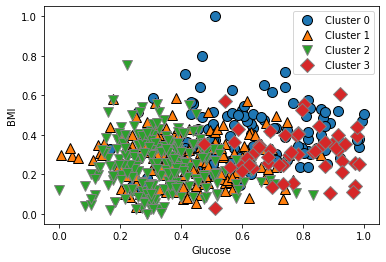

In [61]:
# Agglomerative Clustering -------------------------

from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=4)
assignment = agg.fit_predict(X_train_scaled)


# Scatterplot -----------------------------------

mglearn.discrete_scatter(X_train_scaled.loc[:,"Glucose"], 
                         X_train_scaled.loc[:,"BMI"], 
                         assignment)

plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")

plt.xlabel("Glucose")
plt.ylabel("BMI")

The results for Agglomerative Clustering on the original features seem very similar to the results with K-means.

The two clusters to the right side have higher Glucose values, so they may have higher likelihood of diabetes.

The blue cluster 0 also seems to have slightly higher BMI than the red cluster 3.

Green cluster 1 and and orange cluster 2 seem to have the same general values of BMI.

With these observations, I suspect the chances of diabetes for each cluster goes like this:

- Blue cluster 0 = Highest chance of diabetes


- Red cluster 3 = High chance of diabetes


- Red and Orange clusters 1 & 2 = Low/Medium chance of diabetes


## Dendrogram (Without PCA)

Text(0, 0.5, 'Cluster distance')

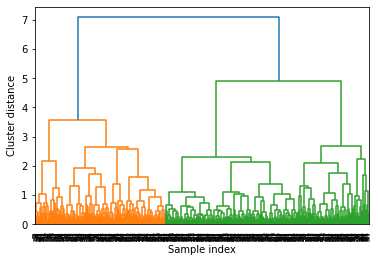

In [62]:
# Dendrogram -----------------------------------

# Import the dendrogram function and the ward clustering function from SciPy
from scipy.cluster.hierarchy import dendrogram, ward

# Apply the ward clustering to the data array X
# The SciPy ward function returns an array that specifies the distances
# bridged when performing agglomerative clustering
linkage_array = ward(X_train_scaled)
# Now we plot the dendrogram for the linkage_array containing the distances
# between clusters
dendrogram(linkage_array)

# mark the cuts in the tree that signify two or three clusters

plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

From this dendrogram, we can see the 4 clusters fairly well. Also, seperating them into just two clusters seems to be a good idea as well.

## Agglomerative Clustering (With PCA)

Text(0, 0.5, 'Second Component')

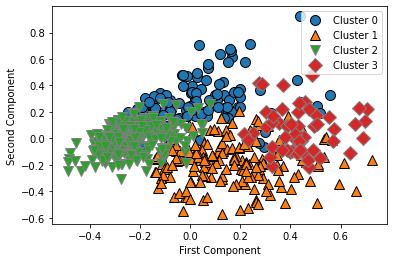

In [63]:
# Agglomerative Clustering -------------------------

from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=4)
assignment = agg.fit_predict(X_train_pca)


# Scatterplot -----------------------------------

mglearn.discrete_scatter(X_train_pca[:,0], 
                         X_train_pca[:,1], 
                         assignment)

plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")

plt.xlabel("First Component")
plt.ylabel("Second Component")

The results for Agglomerative Clustering with PCA components are nearly the same as the results with K-Means.

My attempt at interpreting these clusters are the same as K-Means with PCA:



- Right cluster 3 = High chance of diabetes


- Top cluster 0 = Medium chance of diabetes (younger individuals with genes for type-II)


- Bottom cluster 1 = Medium chance of diabetes (older individuals without genes for type-II)


- Left cluster 2 = Low chance of diabetes


## Dendrogram (With PCA)

Text(0, 0.5, 'Cluster distance')

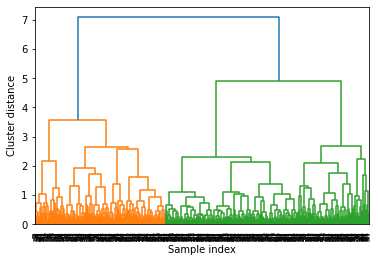

In [64]:
# Dendrogram -----------------------------------

# Import the dendrogram function and the ward clustering function from SciPy
from scipy.cluster.hierarchy import dendrogram, ward

# Apply the ward clustering to the data array X
# The SciPy ward function returns an array that specifies the distances
# bridged when performing agglomerative clustering
linkage_array = ward(X_train_pca)
# Now we plot the dendrogram for the linkage_array containing the distances
# between clusters
dendrogram(linkage_array)

# mark the cuts in the tree that signify two or three clusters

plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

Like this previous dendrogram, we can see the 4 clusters fairly well. Also, seperating them into just two clusters seems to be a good idea as well.

---

## DBSCAN (Without PCA)

Text(0, 0.5, 'BMI')

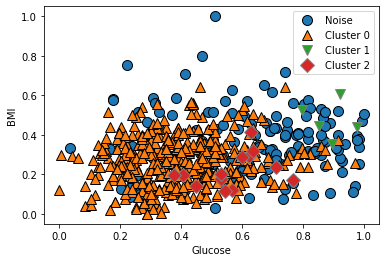

In [65]:
from sklearn.cluster import DBSCAN

# eps - determines distance the algorithm looks for data points
# Increasing eps results in more points per cluster

# min_samples - determines the minimum number of data points within eps distance necessary to form a cluster
# Increasing min_samples results in more being classified as noise

dbscan = DBSCAN(min_samples=5,
                eps=0.22)

clusters = dbscan.fit_predict(X_train_scaled)


mglearn.discrete_scatter(X_train_scaled.loc[:, "Glucose"], 
                         X_train_scaled.loc[:, "BMI"], 
                         clusters)

plt.legend(loc="best")

plt.legend(["Noise",
            "Cluster 0",
            "Cluster 1",
           "Cluster 2"], loc="best")

plt.xlabel("Glucose")
plt.ylabel("BMI")

DBSCAN does not seem to perform well on this data.

When adjusting for various *min_samples* and *eps*, it had these results:

- Too many cases considered noise
- Some clusters are tiny
- One cluster was too large that hogs most of the data points

DBSCAN assumes all clusters will have similar density.

This may be why DBSCAN does not work well with this dataset.

Cases higher in glucose and BMI are considered noise because they are farther apart from one another.

But these cases may be very important since higher Glucose and higher BMI seem to have some correlation with having diabetes!

## DBSCAN (WITH PCA)

Text(0, 0.5, 'Second Component')

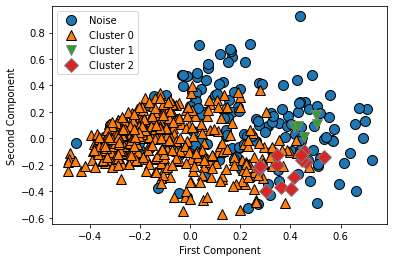

In [66]:
from sklearn.cluster import DBSCAN

# eps - determines distance the algorithm looks for data points
# Increasing eps results in more points per cluster

# min_samples - determines the minimum number of data points within eps distance necessary to form a cluster
# Increasing min_samples results in more being classified as noise


dbscan = DBSCAN(min_samples=5,
                eps=0.22)
clusters = dbscan.fit_predict(X_train_pca)


mglearn.discrete_scatter(X_train_pca[:, 0], 
                         X_train_pca[:, 1], 
                         clusters)

plt.legend(["Noise",
            "Cluster 0",
            "Cluster 1",
           "Cluster 2"], loc="best")

plt.xlabel("First Component")
plt.ylabel("Second Component")

DBSCAN with PCA did not seem to do any better.

- One larger cluster
- Two tiny clusters
- Many data points labeled as noise

---

## Adjusted Rand Index (Without PCA)

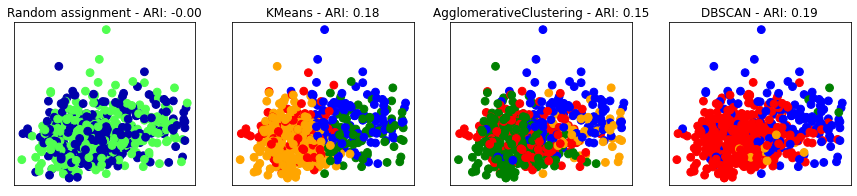

In [67]:
from sklearn.metrics.cluster import adjusted_rand_score
from matplotlib.colors import ListedColormap

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# make a list of algorithms to use
algorithms = [KMeans(n_clusters=4), 
              AgglomerativeClustering(n_clusters=4),
              DBSCAN(min_samples=5,
                eps=0.22)]

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=42)

random_clusters = random_state.randint(low=0, 
                                       high=2, 
                                       size=len(X_train_scaled))

# plot random assignment
axes[0].scatter(X_train_scaled.loc[:, "Glucose"], 
                X_train_scaled.loc[:, "BMI"], 
                c=random_clusters,
                cmap=mglearn.cm3, 
                s=60)


axes[0].set_title("Random assignment - ARI: {:.2f}".format(
        adjusted_rand_score(y_train.hasDiabetes, random_clusters)))

cmap_colors = ListedColormap(["Blue", "Red", "Green", "Orange"])

for ax, algorithm in zip(axes[1:], algorithms):
    
    # plot the cluster assignments and cluster centers
    
    clusters = algorithm.fit_predict(X_train_scaled)
    
    ax.scatter(X_train_scaled.loc[:, "Glucose"], 
                X_train_scaled.loc[:, "BMI"], 
               c=clusters,
               cmap=cmap_colors, s=60)
    
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,
                                           adjusted_rand_score(y_train.hasDiabetes, clusters)))

Overall it seems the ARI scores are pretty low, but it seems KMeans and DBSCAN did the best.

DBSCAN having the highest score is odd because many of the higher Glucose and higher BMI cases were labeled as noise, and the rest of the data points were mostly grouped into one cluster. Maybe ARI also considers "noise" as its own cluster and scored DBSCAN in that way, which in that case, the seperation of clusters seems pretty good!



 ## Adjusted Rand Index (With PCA)

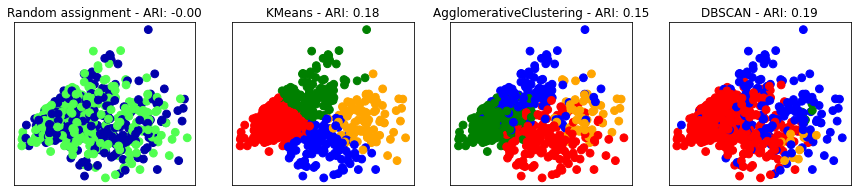

In [68]:
from sklearn.metrics.cluster import adjusted_rand_score
from matplotlib.colors import ListedColormap

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# make a list of algorithms to use
algorithms = [KMeans(n_clusters=4), 
              AgglomerativeClustering(n_clusters=4),
              DBSCAN(min_samples=5,
                eps=0.22)]

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=42)

random_clusters = random_state.randint(low=0, 
                                       high=2, 
                                       size=len(X_train_pca))

# plot random assignment
axes[0].scatter(X_train_pca[:, 0], 
                X_train_pca[:, 1], 
                c=random_clusters,
                cmap=mglearn.cm3, 
                s=60)


axes[0].set_title("Random assignment - ARI: {:.2f}".format(
        adjusted_rand_score(y_train.hasDiabetes, random_clusters)))

cmap_colors = ListedColormap(["Blue", "Red", "Green", "Orange"])

for ax, algorithm in zip(axes[1:], algorithms):
    
    # plot the cluster assignments and cluster centers
    
    clusters = algorithm.fit_predict(X_train_pca)
    
    ax.scatter(X_train_pca[:, 0], 
               X_train_pca[:, 1], 
               c=clusters,
               cmap=cmap_colors, s=60)
    
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,
                                           adjusted_rand_score(y_train.hasDiabetes, clusters)))

With PCA, the ARI scores are all the same as when without PCA.

DBSCAN and KMeans scored the highest again.

## Silhouette Coefficient (Without PCA)

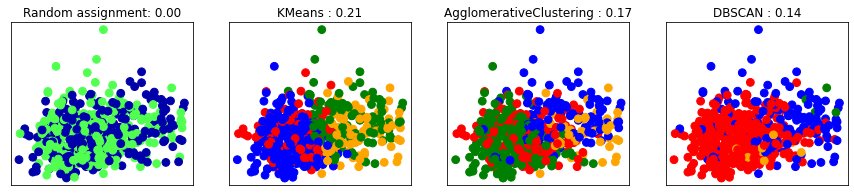

In [69]:
from sklearn.metrics.cluster import silhouette_score
from matplotlib.colors import ListedColormap

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, 
                                       high=2, 
                                       size=len(X_train_scaled))

# plot random assignment
axes[0].scatter(X_train_scaled.loc[:, "Glucose"], 
                X_train_scaled.loc[:, "BMI"], 
                c=random_clusters,
                cmap=mglearn.cm3, s=60)

axes[0].set_title("Random assignment: {:.2f}".format(
    silhouette_score(X_train_scaled, random_clusters)))

algorithms = [KMeans(n_clusters=4), 
              AgglomerativeClustering(n_clusters=4),
              DBSCAN(min_samples=5,
                eps=0.22)]

cmap_colors = ListedColormap(["Blue", "Red", "Green", "Orange"])


for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_train_scaled)
    
    # plot the cluster assignments and cluster centers
    ax.scatter(X_train_scaled.loc[:, "Glucose"], 
                X_train_scaled.loc[:, "BMI"], 
               c=clusters, 
               cmap=cmap_colors,
               s=60)
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__,
                                      silhouette_score(X_train_scaled, clusters)))

With the Silhouette Coefficient, KMeans did the best.

## Silhouette Coefficient (With PCA)

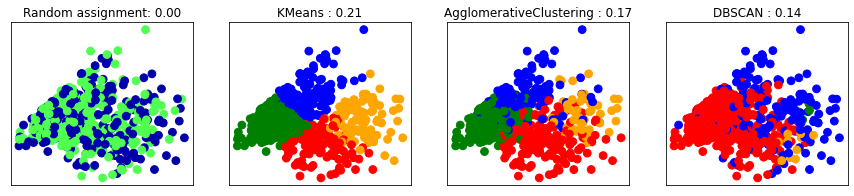

In [70]:
from sklearn.metrics.cluster import silhouette_score
from matplotlib.colors import ListedColormap

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, 
                                       high=2, 
                                       size=len(X_train_pca))

# plot random assignment
axes[0].scatter(X_train_pca[:, 0], 
                X_train_pca[:, 1], 
                c=random_clusters,
                cmap=mglearn.cm3, s=60)

axes[0].set_title("Random assignment: {:.2f}".format(
    silhouette_score(X_train_pca, random_clusters)))

algorithms = [KMeans(n_clusters=4), 
              AgglomerativeClustering(n_clusters=4),
              DBSCAN(min_samples=5,
                eps=0.22)]


cmap_colors = ListedColormap(["Blue", "Red", "Green", "Orange"])

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_train_pca)
    
    # plot the cluster assignments and cluster centers
    ax.scatter(X_train_pca[:, 0], 
               X_train_pca[:, 1], 
               c=clusters, 
               cmap=cmap_colors,
               s=60)
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__,
                                      silhouette_score(X_train_pca, 
                                                       clusters)))

With PCA, all the Silhouette Coefficients are the same as when without PCA.

When considering both ARI and the Silhouette Coefficients, it seems KMeans was the best at clustering the data.

**NOTE:** 

I tried testing ARI and Silhouette Coefficients using 3 clusters instead of 4. 


- With ARI and Silhouette Coefficient, Kmeans did slightly better with 3 clusters.


- With ARI, AgglomerativeClustering did slightly worse with 3 clusters.


    - But with Silhouette Coefficient, AgglomerativeClustering did slightly better with 3 clusters.
    

I likely went too far into the inertia line when conducting the elbow method for KMeans.

**If I were to do this over, I would:**
    
- Use 3 clusters for both KMeans and AgglomerativeClustering


- Maybe conduct ARI and Silhouette Coefficients earlier to decide if 3 or 4 clusters were better.